In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import LinearSVC

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load our localization data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

# load kilosort localization data
ks_unsorted, ks_trials = data_preprocess.load_kilosort_localizations_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=30_000)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


In [55]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] 
ks_structured_unsorted = np.vstack([ks_trials[i] for i in trials_ids])[:,3:]

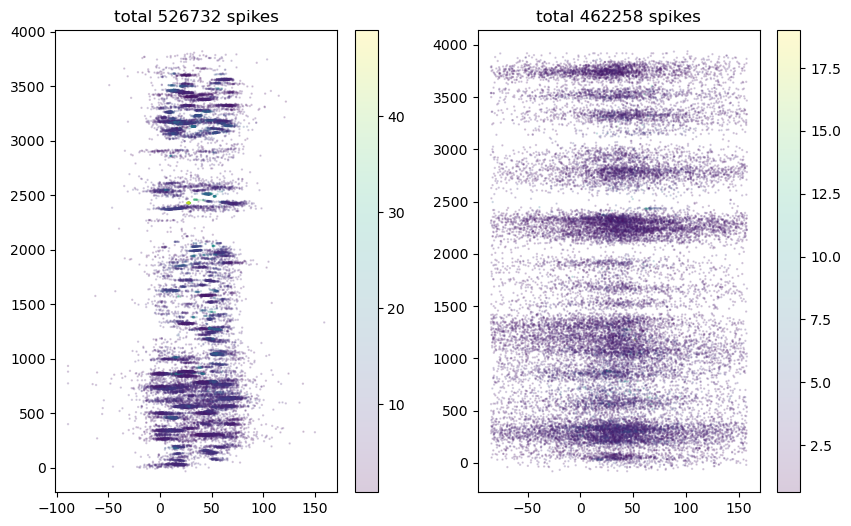

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
p1 = axes[0].scatter(x=structured_unsorted[:30_000,0], y=structured_unsorted[:30_000,1], 
                c=structured_unsorted[:30_000,-1], s=.5, alpha=.2)
axes[0].set_title(f'total {len(structured_unsorted)} spikes')
plt.colorbar(p1, ax=axes[0])
p2 = axes[1].scatter(x=ks_structured_unsorted[:30_000,0], y=ks_structured_unsorted[:30_000,1], 
                c=ks_structured_unsorted[:30_000,-1],s=.5, alpha=.2)
axes[1].set_title(f'total {len(ks_structured_unsorted)} spikes')
plt.colorbar(p2, ax=axes[1])
plt.show()

In [13]:
n_projs = 10
ks_spikes_times, ks_spikes_clusters, ks_spikes_channels = ks_unsorted[:,:3].T
ks_spikes_times = ks_spikes_times / 30_000
ks_unsorted_indices = np.hstack([ks_spikes_times.reshape(-1,1), ks_spikes_channels.reshape(-1,1)])
sorted_neural_data = data_preprocess.compute_time_binned_neural_activity((ks_spikes_times, ks_spikes_clusters), 'sorted', stimulus_onset_times, regional=False)
ks_unsorted_neural_data = data_preprocess.compute_time_binned_neural_activity(ks_unsorted_indices, 'kilosort unsorted', stimulus_onset_times, regional=False)

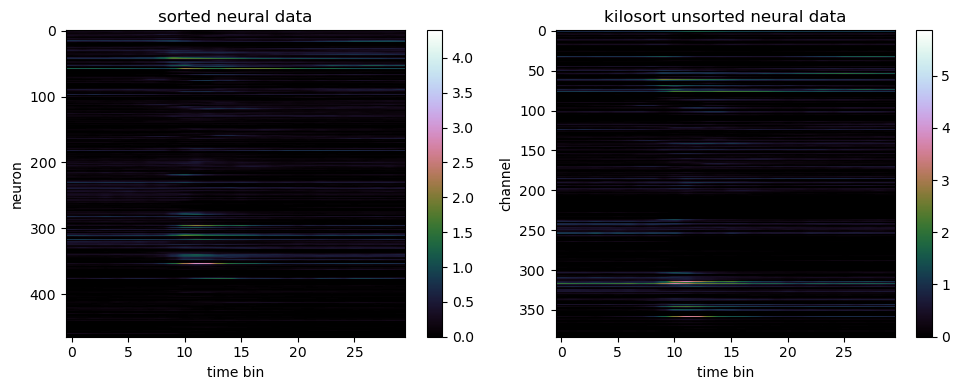

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

p1 = axes[0].imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('sorted neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('neuron')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(ks_unsorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('kilosort unsorted neural data')
axes[1].set_xlabel('time bin')
axes[1].set_ylabel('channel')
plt.colorbar(p2, ax=axes[1]);

plt.tight_layout()
plt.show()

In [17]:
print('sorted decoding ...')
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(sorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(sorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

print('kilosort thresholded decoding ...')
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(ks_unsorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(ks_unsorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

sorted decoding ...
choice fold 1 test accuracy: 0.935 auc: 0.990
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.978 auc: 0.998
choice fold 5 test accuracy: 0.957 auc: 0.998
choice mean of 5-fold cv accuracy: 0.970 auc: 0.997
choice sd of 5-fold cv accuracy: 0.022 auc: 0.004
stimulus fold 1 test accuracy: 0.196 auc: 0.785
stimulus fold 2 test accuracy: 0.326 auc: 0.820
stimulus fold 3 test accuracy: 0.370 auc: 0.823
stimulus fold 4 test accuracy: 0.261 auc: 0.814
stimulus fold 5 test accuracy: 0.457 auc: 0.823
stimulus mean of 5-fold cv accuracy: 0.322 auc: 0.813
stimulus sd of 5-fold cv accuracy: 0.090 auc: 0.014
kilosort thresholded decoding ...
choice fold 1 test accuracy: 0.913 auc: 0.983
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.957 auc: 0.996
choice fold 5 test accuracy: 0.957 auc: 0.996
choice mean of 5-fold cv accuracy: 0.9

visualize our localization

In [7]:
initial_gmm = init_gmm.initial_gaussian_mixtures('..', sub_id, trials, n_gaussians=400, seed=seed, fit_model=True)
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


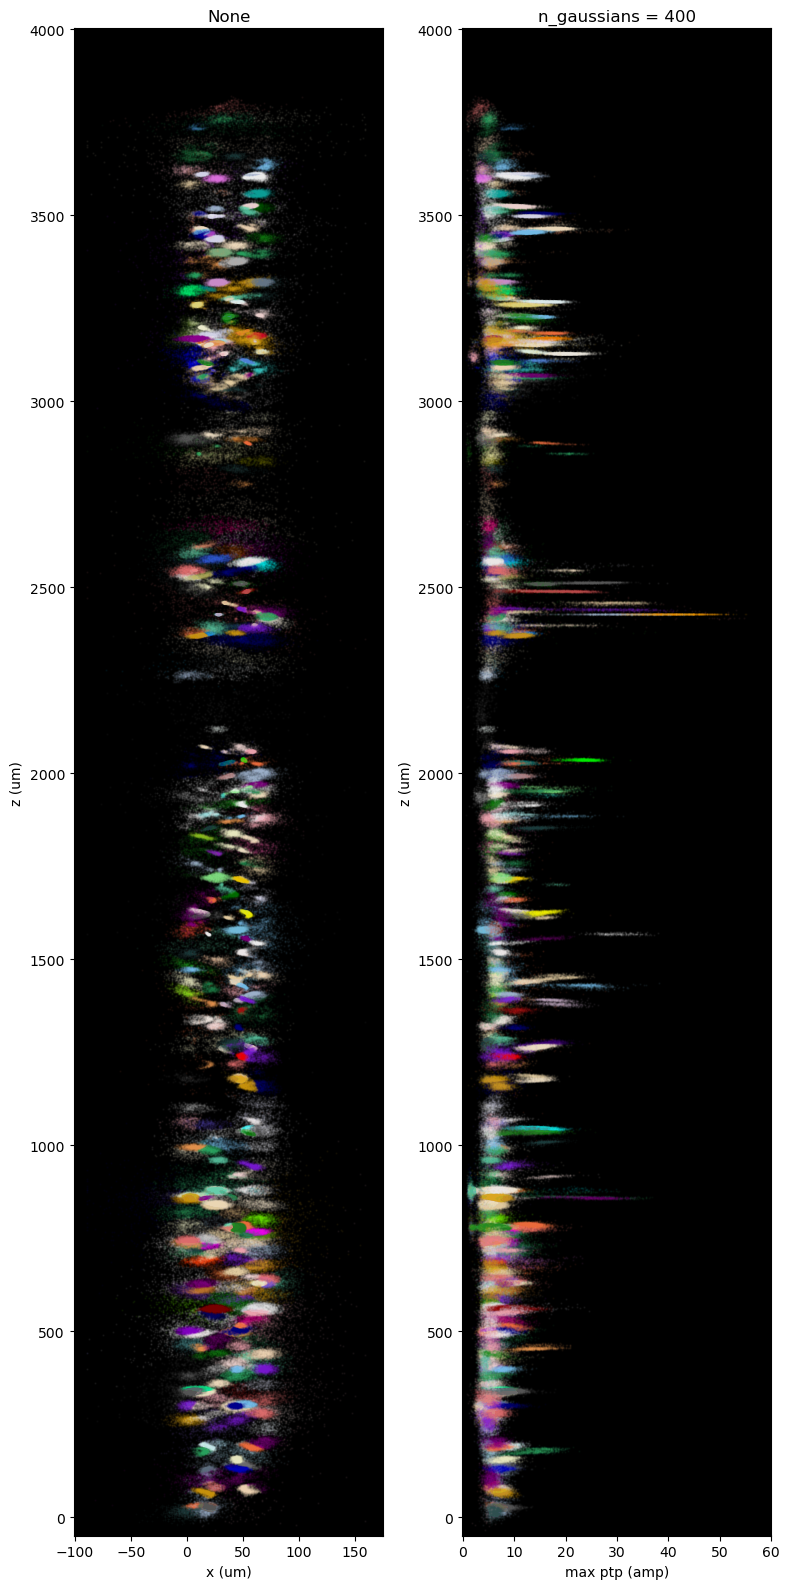

In [8]:
viz_tools.plot_gaussian_mixtures(sub_id, structured_unsorted, initial_labels, initial_labels, display_all_spikes=True, n_spikes_display=1_000)

In [31]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 400, 30)
clusterless neural projections shape: (230, 400, 15)
clusterless neural reconstructions shape: (230, 400, 30)


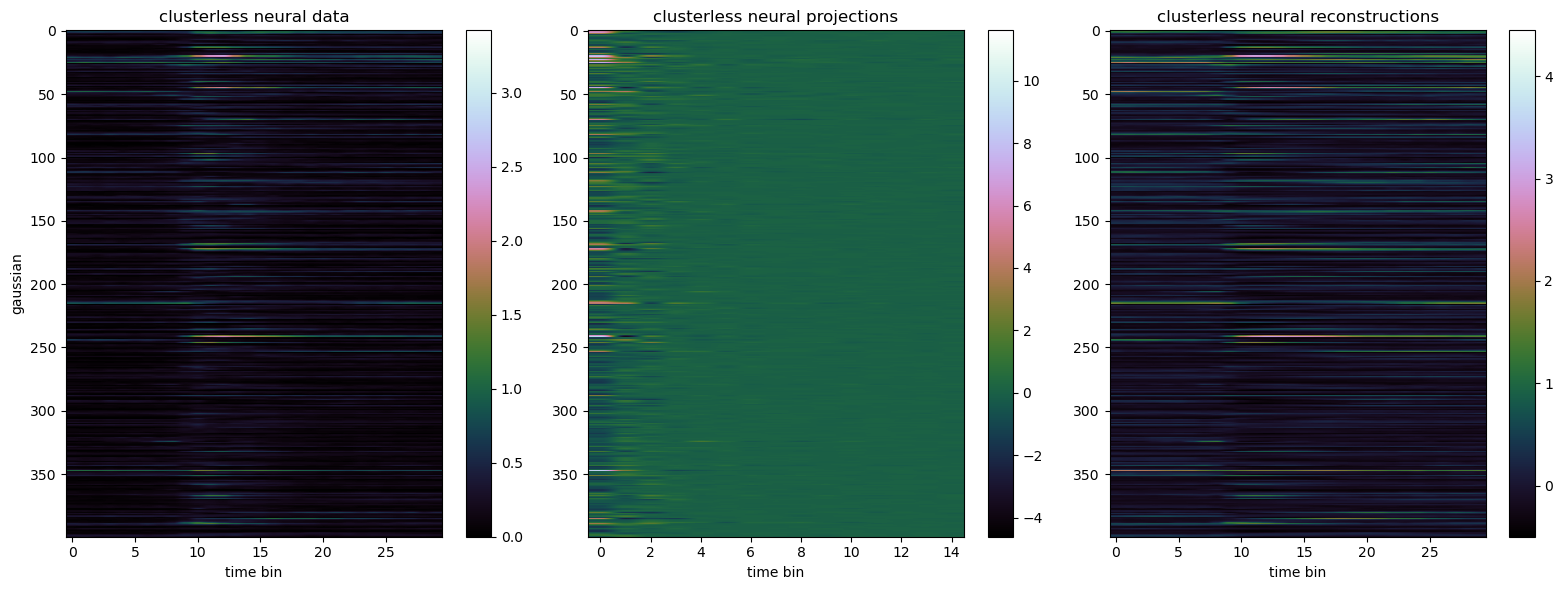

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [11]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.985
choice fold 2 test accuracy: 0.957 auc: 0.981
choice fold 3 test accuracy: 0.957 auc: 0.992
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 0.978 auc: 1.000
choice mean of 5-fold cv accuracy: 0.948 auc: 0.988
choice sd of 5-fold cv accuracy: 0.022 auc: 0.007
stimulus fold 1 test accuracy: 0.261 auc: 0.785
stimulus fold 2 test accuracy: 0.239 auc: 0.790
stimulus fold 3 test accuracy: 0.391 auc: 0.828
stimulus fold 4 test accuracy: 0.261 auc: 0.800
stimulus fold 5 test accuracy: 0.370 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.804
stimulus sd of 5-fold cv accuracy: 0.063 auc: 0.016


visualize feature importance of MoG weights

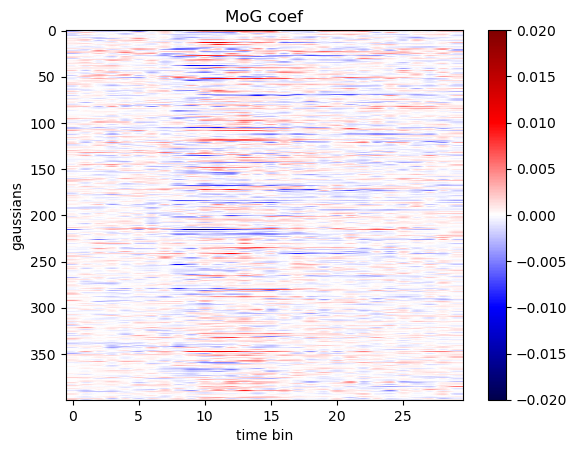

In [ ]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()

model selection using AIC:

https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

In [153]:
sample_spikes = [trial[np.random.choice(len(trial), 500), 1:] for trial in trials]
sample_spikes = np.vstack(sample_spikes)
print(len(sample_spikes))

115000


In [154]:
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
lowest_bic = np.infty
aic = []; bic = []
k_range = range(500, 1100, 100)

for k in k_range:
    print(f'--- fitting MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
    gmm.fit(sample_spikes)
    aic.append(gmm.aic(sample_spikes))
    bic.append(gmm.bic(sample_spikes))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_aic_gmm = gmm
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current aic: {round(aic[-1],2)} bic: {round(bic[-1],2)}')
    print(f'best aic MoG has {len(best_aic_gmm.weights_)} gaussians.')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fitting MoG with 500 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3026611.98 bic: 3074865.76
best aic MoG has 500 gaussians.
best bic MoG has 500 gaussians.
--- fitting MoG with 600 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3020780.59 bic: 3078687.06
best aic MoG has 600 gaussians.
best bic MoG has 500 gaussians.
--- fitting MoG with 700 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3016876.05 bic: 3084435.21
best aic MoG has 700 gaussians.
best bic MoG has 500 gaussians.
--- fitting MoG with 800 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3015300.98 bic: 3092512.83
best aic MoG has 800 gaussians.
best bic MoG has 500 gaussians.
--- fitting MoG with 900 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True

In [157]:
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
lowest_bic = np.infty
aic = []; bic = []
k_range = range(300, 600, 100)

for k in k_range:
    print(f'--- fitting MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
    gmm.fit(sample_spikes)
    aic.append(gmm.aic(sample_spikes))
    bic.append(gmm.bic(sample_spikes))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_aic_gmm = gmm
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current aic: {round(aic[-1],2)} bic: {round(bic[-1],2)}')
    print(f'best aic MoG has {len(best_aic_gmm.weights_)} gaussians.')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fitting MoG with 300 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3047759.26 bic: 3076707.67
best aic MoG has 300 gaussians.
best bic MoG has 300 gaussians.
--- fitting MoG with 400 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3031289.76 bic: 3069890.86
best aic MoG has 400 gaussians.
best bic MoG has 400 gaussians.
--- fitting MoG with 500 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3026611.98 bic: 3074865.76
best aic MoG has 500 gaussians.
best bic MoG has 400 gaussians.


In [160]:
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
lowest_bic = np.infty
aic = []; bic = []
k_range = range(300, 410, 10)

for k in k_range:
    print(f'--- fitting MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
    gmm.fit(sample_spikes)
    aic.append(gmm.aic(sample_spikes))
    bic.append(gmm.bic(sample_spikes))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_aic_gmm = gmm
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current aic: {round(aic[-1],2)} bic: {round(bic[-1],2)}')
    print(f'best aic MoG has {len(best_aic_gmm.weights_)} gaussians.')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fitting MoG with 300 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3047759.26 bic: 3076707.67
best aic MoG has 300 gaussians.
best bic MoG has 300 gaussians.
--- fitting MoG with 310 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3045168.21 bic: 3075081.89
best aic MoG has 310 gaussians.
best bic MoG has 310 gaussians.
--- fitting MoG with 320 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3042474.85 bic: 3073353.8
best aic MoG has 320 gaussians.
best bic MoG has 320 gaussians.
--- fitting MoG with 330 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3040738.51 bic: 3072582.73
best aic MoG has 330 gaussians.
best bic MoG has 330 gaussians.
--- fitting MoG with 340 gaussians ---
Initialization 0
 

In [163]:
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
lowest_bic = np.infty
aic = []; bic = []
k_range = range(400, 500, 10)

for k in k_range:
    print(f'--- fitting MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
    gmm.fit(sample_spikes)
    aic.append(gmm.aic(sample_spikes))
    bic.append(gmm.bic(sample_spikes))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_aic_gmm = gmm
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current aic: {round(aic[-1],2)} bic: {round(bic[-1],2)}')
    print(f'best aic MoG has {len(best_aic_gmm.weights_)} gaussians.')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fitting MoG with 400 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3031289.76 bic: 3069890.86
best aic MoG has 400 gaussians.
best bic MoG has 400 gaussians.
--- fitting MoG with 410 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 3033926.04 bic: 3073492.41
best aic MoG has 400 gaussians.
best bic MoG has 400 gaussians.
--- fitting MoG with 420 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3033012.05 bic: 3073543.68
best aic MoG has 400 gaussians.
best bic MoG has 400 gaussians.
--- fitting MoG with 430 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3031640.18 bic: 3073137.08
best aic MoG has 400 gaussians.
best bic MoG has 400 gaussians.
--- fitting MoG with 440 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20


visualize kilosort localization

In [75]:
sample_spikes = [trial[np.random.choice(len(trial), 500), 3:] for trial in ks_trials]
sample_spikes = np.vstack(sample_spikes)
print(sample_spikes.shape)

(115000, 3)


In [77]:
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
lowest_bic = np.infty
aic = []; bic = []
k_range = range(50, 150, 10)

for k in k_range:
    print(f'--- fitting MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
    gmm.fit(sample_spikes)
    aic.append(gmm.aic(sample_spikes))
    bic.append(gmm.bic(sample_spikes))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_aic_gmm = gmm
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current aic: {round(aic[-1],2)} bic: {round(bic[-1],2)}')
    print(f'best aic MoG has {len(best_aic_gmm.weights_)} gaussians.')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fitting MoG with 50 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3307635.34 bic: 3312452.03
best aic MoG has 50 gaussians.
best bic MoG has 50 gaussians.
--- fitting MoG with 60 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3306176.59 bic: 3311958.55
best aic MoG has 60 gaussians.
best bic MoG has 60 gaussians.
--- fitting MoG with 70 gaussians ---
Initialization 0
  Iteration 10
Initialization converged: True
current aic: 3304662.31 bic: 3311409.54
best aic MoG has 70 gaussians.
best bic MoG has 70 gaussians.
--- fitting MoG with 80 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3303394.92 bic: 3311107.41
best aic MoG has 80 gaussians.
best bic MoG has 80 gaussians.
--- fitting MoG with 90 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 3302618.04 bic

In [78]:
trials_ids = np.arange(len(trials))
random.seed(seed)
random.shuffle(trials_ids)
shuffled_unsorted = np.vstack([ks_trials[i] for i in trials_ids])[:,3:]

In [79]:
trials_ids = np.arange(len(trials))
random.seed(seed)
random.shuffle(trials_ids)
shuffled_unsorted = np.vstack([ks_trials[i] for i in trials_ids])[:,3:]

ks_gmm = GaussianMixture(
        init_params='kmeans',
        n_components=80, covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
ks_gmm.fit(shuffled_unsorted)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=80, random_state=666, verbose=1, warm_start=True)

In [80]:
ks_labels = ks_gmm.predict(ks_structured_unsorted)
ks_probs = ks_gmm.predict_proba(ks_structured_unsorted)

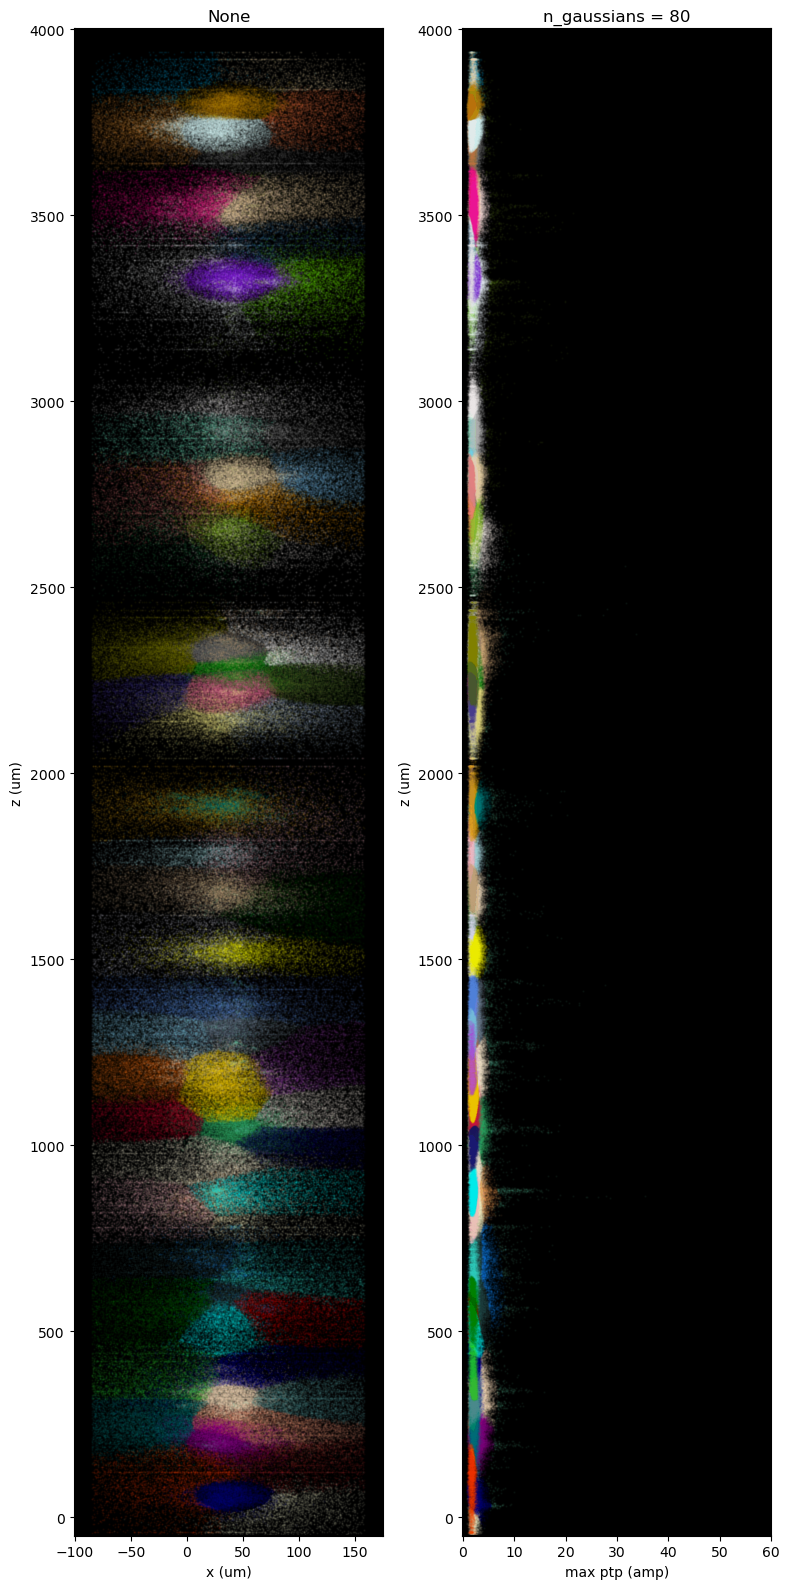

In [81]:
viz_tools.plot_gaussian_mixtures(sub_id, ks_structured_unsorted, ks_labels, ks_labels, display_all_spikes=True, n_spikes_display=1_000)

In [82]:
ks_spikes_times = np.vstack([ks_trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((ks_spikes_times, ks_labels, ks_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 80, 30)
clusterless neural projections shape: (230, 80, 15)
clusterless neural reconstructions shape: (230, 80, 30)


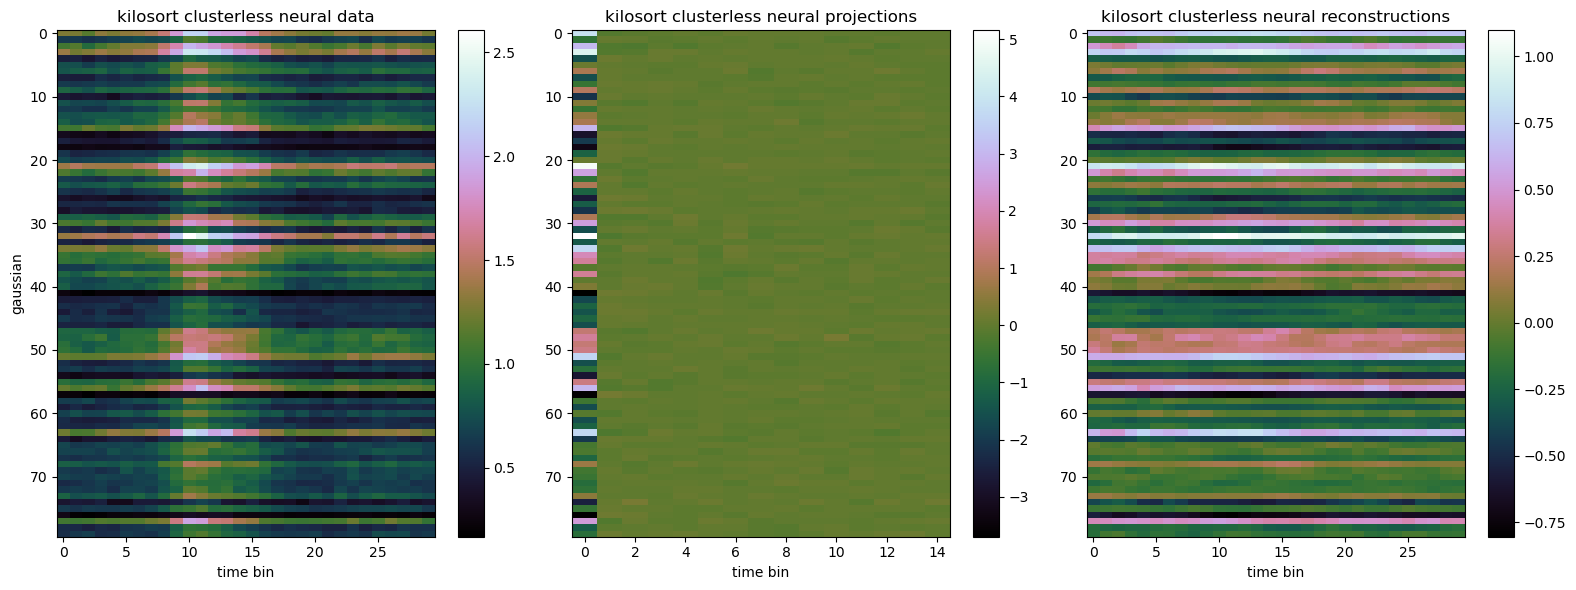

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('kilosort clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('kilosort clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('kilosort clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [84]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.652 auc: 0.671
choice fold 2 test accuracy: 0.717 auc: 0.733
choice fold 3 test accuracy: 0.848 auc: 0.897
choice fold 4 test accuracy: 0.739 auc: 0.797
choice fold 5 test accuracy: 0.761 auc: 0.708
choice mean of 5-fold cv accuracy: 0.743 auc: 0.761
choice sd of 5-fold cv accuracy: 0.064 auc: 0.079
stimulus fold 1 test accuracy: 0.130 auc: 0.616
stimulus fold 2 test accuracy: 0.196 auc: 0.612
stimulus fold 3 test accuracy: 0.174 auc: 0.574
stimulus fold 4 test accuracy: 0.152 auc: 0.628
stimulus fold 5 test accuracy: 0.174 auc: 0.573
stimulus mean of 5-fold cv accuracy: 0.165 auc: 0.601
stimulus sd of 5-fold cv accuracy: 0.022 auc: 0.023
